In [7]:
!git clone https://github.com/sandeshbhatjr/googlehashcode2020.git

fatal: destination path 'googlehashcode2020' already exists and is not an empty directory.


In [8]:
import os

list_of_filenames = os.listdir('googlehashcode2020/input')
input_keys = [filename[0] for filename in list_of_filenames]
list_of_filepaths = ['googlehashcode2020/input/' + filename for filename in list_of_filenames]
file_dict = dict(zip(input_keys, list_of_filepaths))

file_dict

{'a': 'googlehashcode2020/input/a_example.txt',
 'b': 'googlehashcode2020/input/b_read_on.txt',
 'c': 'googlehashcode2020/input/c_incunabula.txt',
 'd': 'googlehashcode2020/input/d_tough_choices.txt',
 'e': 'googlehashcode2020/input/e_so_many_books.txt',
 'f': 'googlehashcode2020/input/f_libraries_of_the_world.txt'}

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random

class library_scanning_strategy:
  def __init__(self, nBooks, nLibraries, nDays, bookScores, libraryList, filename):
    self.nBooks = nBooks
    self.nLibraries = nLibraries
    self.nDays = nDays
    self.bookScores = bookScores
    self.libraryList = libraryList
    self.librarySignupDays = [library['signupDays'] for library in self.libraryList]
    self.libraryBookspDay = [library['books/day'] for library in self.libraryList]
    self.filename_short = filename.split('/')[2][0]
  @classmethod
  def from_file(cls, filename):
    with open(filename) as f:
      lines = f.read().split('\n')
      nBooks, nLibraries, nDays = map(lambda x: int(x), lines[0].split(' '))
      bookScores = np.array(list(map(lambda x: int(x), lines[1].split(' '))))
      libraryList = []
      for i in range(nLibraries):
        tempDict = {}
        tempDict['nBooks'], tempDict['signupDays'], tempDict['books/day'] = map(lambda x: int(x), lines[(2*i)+2].split(' '))
        tempDict['booksList'] = np.array(list(map(lambda x: int(x), lines[(2*i)+3].split(' '))))
        libraryList.append(tempDict)
      return cls(nBooks, nLibraries, nDays, bookScores, libraryList, filename)
  def book_occurence_matrix(self, strategy):
    """ 
      A generator to yield book occurence matrix for a given strategy,
      in the order of libraries as given by the strategy list.
    """
    for i, library in enumerate(strategy):
      occurence_matrix = np.zeros([self.nBooks], dtype=bool)
      occurence_matrix[np.array(library['books_to_scan'])] = True
      yield i, library, occurence_matrix
  def scanning_days(self, strategy):
    signUpdays = np.array([self.librarySignupDays[library['id']] for library in strategy])
    readyOnDay = np.cumsum(signUpdays)
    temp_sd = (self.nDays - readyOnDay)
    return (temp_sd > 0)*temp_sd
  def redundancy(self, strategy):
    library_id_list = [library['id'] for library in strategy]
    scanning_days_list = self.scanning_days(strategy)
    scanning_days_dict = dict(zip(library_id_list, scanning_days_list))
    scan_array = np.zeros([len(self.bookScores)])
    for i, (library_id, scanning_days) in enumerate(scanning_days_dict.items()):
      books_to_scan = strategy[i]['books_to_scan']
      max_books_that_can_be_scanned = self.libraryList[library_id]['books/day']*scanning_days
      N = min([max_books_that_can_be_scanned, len(books_to_scan)])
      books_scanned = books_to_scan[:N]
      if len(books_scanned) > 0:
        scan_array[np.array(books_scanned)] += 1
    return scan_array
  def score(self, strategy):
    scan_array = self.redundancy(strategy)
    return (scan_array != 0)@self.bookScores
  def generate_random_strategy(self):
    random_strategy = []
    sequence = [i for i in range(len(self.libraryList))]
    np.random.shuffle(sequence)
    for i in sequence:
      temp_dict = {}
      temp_dict['id'] = i
      book_sequence = self.libraryList[i]['booksList']
      np.random.shuffle(book_sequence)
      temp_dict['books_to_scan'] = book_sequence
      random_strategy.append(temp_dict)
    return random_strategy
  def sort_books_by_score(self, strategy):
    book_sorted_strategy = strategy
    oneup_books_array = np.arange(1, self.nBooks + 1)
    for _, library, o_matrix in self.book_occurence_matrix(book_sorted_strategy):
      book_array = oneup_books_array*o_matrix
      sorted_book_array = book_array[np.argsort(-self.bookScores)]
      library['books_to_scan'] = list(sorted_book_array[sorted_book_array != 0] - 1)
    return book_sorted_strategy
  def generate_sorted_strategy(self):
    sorted_strategy = []
    signup_days = np.array([library['signupDays'] for library in self.libraryList])
    sorted_library_order = np.argsort(signup_days)
    for i in sorted_library_order:
      temp_dict = {}
      temp_dict['id'] = i
      book_sequence = self.libraryList[i]['booksList']
      np.random.shuffle(book_sequence)
      temp_dict['books_to_scan'] = book_sequence
      sorted_strategy.append(temp_dict)
    return sorted_strategy
  def random_swap_strategy(self, strategy, swap_item):
    if swap_item is 'library':
      return np.random.permutation(strategy)
    if swap_item is 'book':
      random_library = np.random.randint(len(strategy))
      strategy[random_library]['books_to_scan'] = np.random.permutation(strategy[random_library]['books_to_scan'])
      return strategy
  def remove_redundancy_and_sort_by_score(self, strategy):
    non_redundant_strategy = strategy
    csum_o_matrix = np.zeros(self.nBooks)
    oneup_books_array = np.arange(1, self.nBooks + 1)
    for i, library, o_matrix in self.book_occurence_matrix(non_redundant_strategy):
      csum_o_matrix += o_matrix
      masked_csum_o_matrix = o_matrix*csum_o_matrix
      repeated_books = oneup_books_array*(masked_csum_o_matrix > 1)
      non_repeated_books = oneup_books_array*(masked_csum_o_matrix == 1)
      sorted_non_repeated_books = non_repeated_books[np.argsort(-self.bookScores)]
      library['books_to_scan'] = \
        list(sorted_non_repeated_books[sorted_non_repeated_books != 0] - 1) + \
        list(repeated_books[repeated_books != 0] - 1)
    return non_redundant_strategy
  def output_strategy(self, filename, strategy):
    with open(filename, 'w') as f:
      f.write(str(len(strategy)))
      for library in strategy:
        f.write('\n')
        f.write(str(library['id']) + ' ' + str(len(library['books_to_scan'])))
        f.write('\n')
        books_to_scan_list_as_string = list(map(lambda x: str(x), library['books_to_scan']))
        f.write(' '.join(books_to_scan_list_as_string))

a = library_scanning_strategy.from_file(file_dict['a'])
b = library_scanning_strategy.from_file(file_dict['b'])
c = library_scanning_strategy.from_file(file_dict['c'])
d = library_scanning_strategy.from_file(file_dict['d'])
e = library_scanning_strategy.from_file(file_dict['e'])
f = library_scanning_strategy.from_file(file_dict['f'])

Let's test our scoring on the example given.

In [10]:
strategy = [
    {'id': 1, 'nBooks': 3, 'books_to_scan': [5, 2, 3]},
    {'id': 0, 'nBooks': 5, 'books_to_scan': [0, 1, 2, 3, 4]}
]

a.score(strategy)

16

### MC based random sampling
The idea is to use simulated annealing, starting with a sorted configuration. Further the books are sorted. At the end of a few rounds, the maximum scores are taken, and the redundant books are moved to the end to further increase score.

In [0]:
def simulated_annealing(library_set, start_strategy, T, reduce_interval=100, library_swap_prob=0.9, swap_step=1, iteration=1000, plot=True):
  max_strategy_history = []
  score_history = np.zeros(0)
  current_strategy = start_strategy
  current_score = library_set.score(current_strategy)
  max_score = current_score
  for i in range(iteration):
    # reduce temperature
    T = T * (np.exp((-10)/iteration))
    # swap
    temp_new_strategy = current_strategy
    for j in range(swap_step):
      swap_type = random.choices(['book', 'library'], weights=[1-library_swap_prob,library_swap_prob])[0]
      temp_new_strategy = library_set.random_swap_strategy(temp_new_strategy, swap_type)
    new_strategy = temp_new_strategy
    new_score = library_set.score(new_strategy)
    # accept/reject change
    deltaE = (new_score - current_score)
    metropolis_factor = min([1, np.exp(deltaE/T)])
    p = np.random.random()
    if (p < metropolis_factor):
      # update
      if new_score > max_score:
        library_set.output_strategy('output_'+library_set.filename_short+str(new_score)+'.txt', new_strategy)
        max_score = new_score
        max_strategy_history.append(new_strategy)
      current_strategy = new_strategy
      current_score = new_score
      score_history = np.concatenate([score_history, [new_score]])
    # reduce the best strategies
    if ((i%reduce_interval == 0 and i != 0) or (i == iteration - 1)) and (len(max_strategy_history) != 0):
      max_score_history = list(map(lambda x: library_set.score(x), max_strategy_history))
      max_strategy = max_strategy_history[np.argsort(-np.array(max_score_history))[0]]
      reduced_max_strategy = library_set.remove_redundancy_and_sort_by_score(max_strategy)
      reduced_max_score = library_set.score(reduced_max_strategy)
      print("Max score {} reduced to {}".format(max_score, reduced_max_score))
      library_set.output_strategy('output_'+library_set.filename_short+str(reduced_max_score)+'.txt', reduced_max_strategy)
  # plot scores
  if plot is True:
    plt.figure(figsize=(15,8))
    plt.plot(score_history)
  return current_strategy, score_history

Sort Library: 5822900
Remove redundancy: 5822900


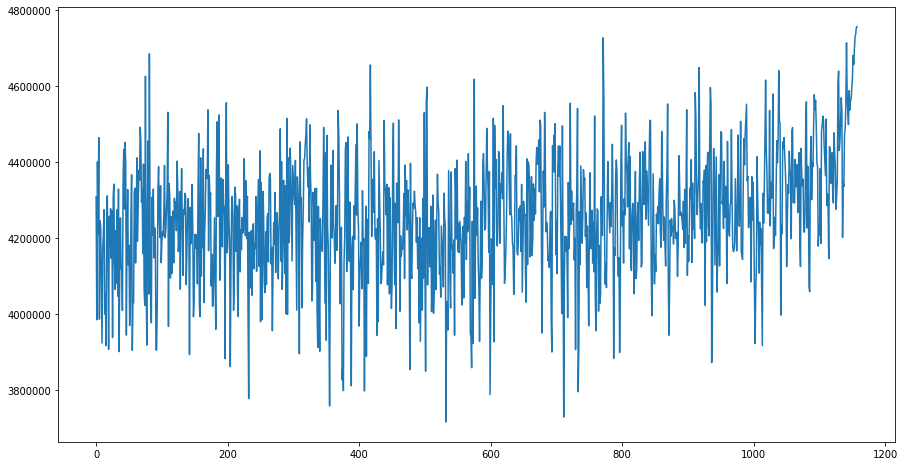

In [12]:
# sort it
sorted_strategy = b.generate_sorted_strategy()
print("Sort Library: {}".format(b.score(sorted_strategy)))
special_strategy = b.sort_books_by_score(sorted_strategy)
print("Remove redundancy: {}".format(b.score(special_strategy)))
strategy_at_end_of_stage = special_strategy
strategy_at_end_of_stage, score_history = simulated_annealing(
      b, 
      strategy_at_end_of_stage, 
      b.score(special_strategy)/10, 
      swap_step = 2, 
      library_swap_prob = 1,
      iteration = 10000,
      plot = True)

Sort Library: 5467966
Sort Books: 5467966


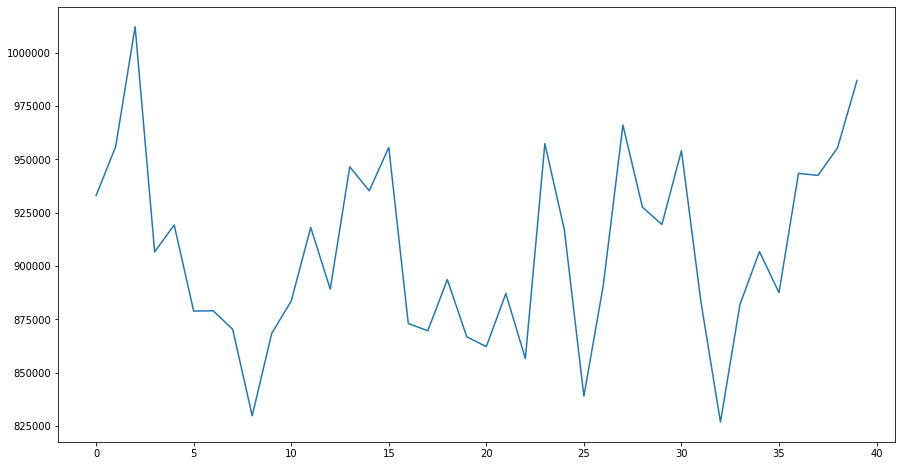

In [13]:
# sort it
sorted_strategy = c.generate_sorted_strategy()
print("Sort Library: {}".format(c.score(sorted_strategy)))
special_strategy = c.sort_books_by_score(sorted_strategy)
print("Sort Books: {}".format(c.score(special_strategy)))
strategy_at_end_of_stage = special_strategy
strategy_at_end_of_stage, score_history = simulated_annealing(
      c, 
      strategy_at_end_of_stage, 
      c.score(special_strategy), 
      swap_step = 5, 
      library_swap_prob = 1,
      iteration = 100,
      plot = True)

**b,c** do not seem to move a lot above the simple sorted strategy. I think they are pretty much near the maxima, and a global maxima (if it exists) is quite far away from wherever we are. Since huge jumps are necessary for it to even move (much less increase), we can assume MC methods will not do great to improve on that bound there.

Sort Library: 4103450
Remove redundancy: 4103450
Max score 4366115 reduced to 4366310
Max score 4368715 reduced to 4368975


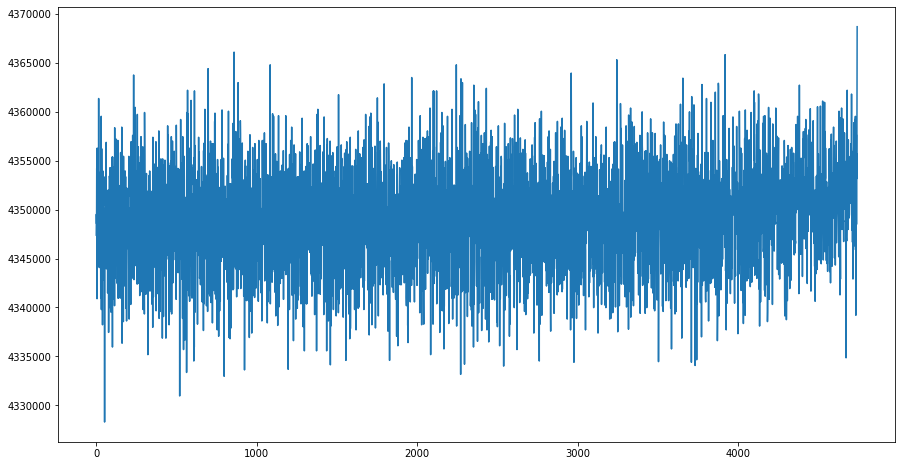

In [14]:
# sort it
sorted_strategy = d.generate_sorted_strategy()
print("Sort Library: {}".format(d.score(sorted_strategy)))
special_strategy = d.sort_books_by_score(sorted_strategy)
print("Sort books: {}".format(d.score(special_strategy)))
strategy_at_end_of_stage = special_strategy
strategy_at_end_of_stage, score_history = simulated_annealing(
      d, 
      strategy_at_end_of_stage, 
      d.score(special_strategy)/5, 
      swap_step = 5, 
      library_swap_prob = 1,
      iteration = 10000,
      reduce_interval = 5000,
      plot = True)

Sort Library: 2811353
Remove redundancy: 3651571


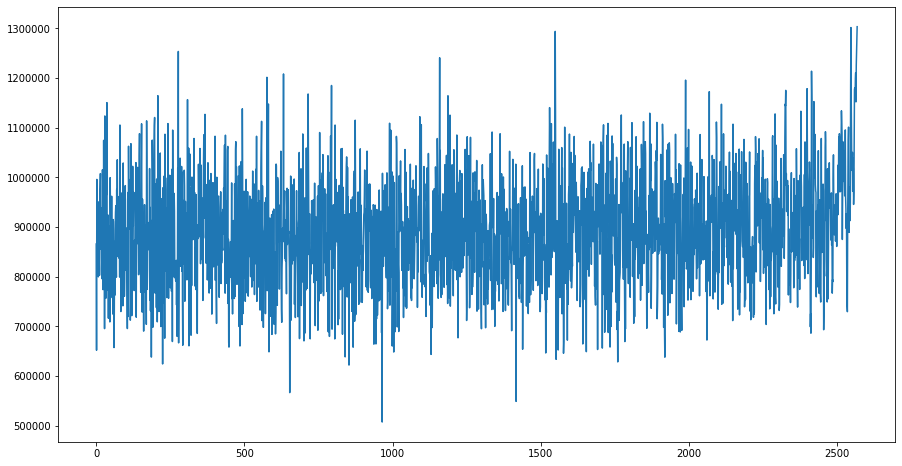

In [15]:
# sort it
sorted_strategy = e.generate_sorted_strategy()
print("Sort Library: {}".format(e.score(sorted_strategy)))
special_strategy = e.sort_books_by_score(sorted_strategy)
print("Remove redundancy: {}".format(e.score(special_strategy)))
strategy_at_end_of_stage = special_strategy
strategy_at_end_of_stage, score_history = simulated_annealing(
      e, 
      strategy_at_end_of_stage, 
      e.score(special_strategy)/2, 
      swap_step = 25, 
      library_swap_prob = 1,
      reduce_interval = 5000,
      iteration = 10000,
      plot = True)

Sort Library: 2600519
Sort books: 2592760


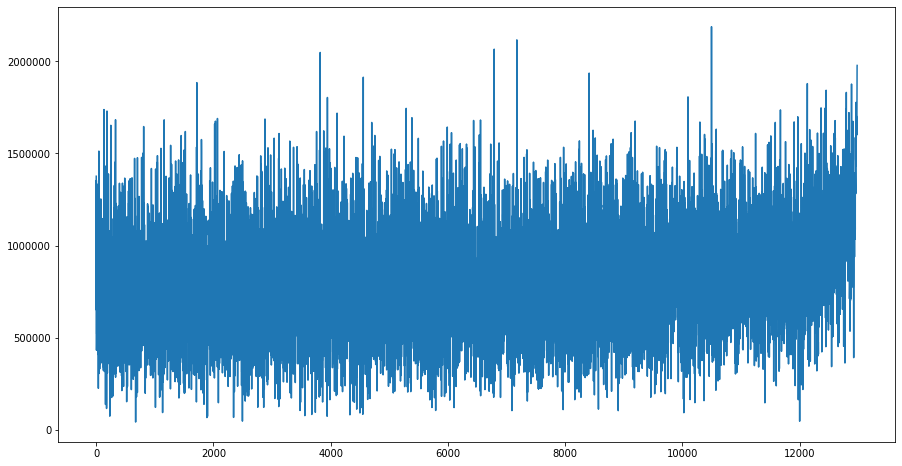

In [16]:
# sort it
sorted_strategy = f.generate_sorted_strategy()
print("Sort Library: {}".format(f.score(sorted_strategy)))
special_strategy = e.sort_books_by_score(sorted_strategy)
print("Sort books: {}".format(f.score(special_strategy)))
strategy_at_end_of_stage = special_strategy
strategy_at_end_of_stage, score_history = simulated_annealing(
      f, 
      strategy_at_end_of_stage, 
      f.score(special_strategy)/2,  
      swap_step = 1, 
      library_swap_prob = 1,
      reduce_interval = 1000,
      iteration = 100000,
      plot = True)